# Release Notes

上一个版本：3.1-FE-KeepTheFeaturesAsTheyOriginallyWere

开展一些特征工程，试图提高表现。上一版本得到的结果，成绩是391名。

忙了一天，终于把所有的步骤跑通了。下一步就是做更多的特征工程，如有条件，就调试一下算法。

最后结果发现，xgb效果还行。以后，如有新的FE策略，就用CAT测试效果，看有无提高。最终的结果还是用xgb来弄吧。

本地跑CAT以及测试，最终的结果用xgb来弄吧，如果足够快的话。

# Setting working directory

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/MachineLearningPractice/XiamenIntlBank')

Go to this place for original dataset: 

`'/content/drive/My Drive/Colab Notebooks/MachineLearningPractice/FinanceRiskControl/originalDataset'`

In [ ]:
## 安装catboost和lightgbm。
## catboost耗费显存极大，但是飞快；lightgbm好像不是那么的方便，gpu使用不起来。
!pip install catboost
# !pip uninstall lightgbm
# !pip install lightgbm --install-option=--gpu --install-option="--opencl-include-dir=/usr/local/cuda/include/" --install-option="--opencl-library=/usr/local/cuda/lib64/libOpenCL.so"

# Importing libraries and load datasets

In [2]:
# !pip install catboost

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor, CatBoostClassifier
import warnings
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss, cohen_kappa_score
# import tqdm
from collections import Counter, defaultdict
import tensorflow as tf
import random
warnings.filterwarnings('ignore')

# Rudimentary processing

Like encoding some object type data

## Load dataset

In [46]:
data_train = pd.read_csv('preprocessedData/quarter3_merged-validLabels.csv')
data_test_a = pd.read_csv('preprocessedData/quarter1_merged-validUsers.csv')

## Delete the cols that have too many null

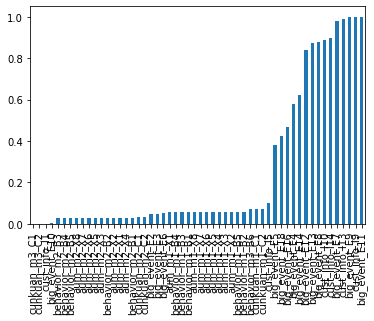

In [47]:
# nan可视化
def seeWhichColumnsHaveMissingValues(data_train): 
    missing = data_train.isnull().sum()/len(data_train)
    missing = missing[missing > 0]
    missing.sort_values(inplace=True)
#     print((missing))
    missing.plot.bar()
seeWhichColumnsHaveMissingValues(data_train)

In [48]:
def seeWhichColumnsHaveMissingValuesMoreThanAThreshold(data_train, threshold): 
    missing = data_train.isnull().sum()/len(data_train)
    missing = missing[missing > threshold]
    missing.sort_values(inplace=True)
    return list(missing.index)
colsThatHaveTooManyNull = seeWhichColumnsHaveMissingValuesMoreThanAThreshold(data_train, 0.15)
print(colsThatHaveTooManyNull)

['big_event_E5', 'big_event_E18', 'big_event_E16', 'big_event_E4', 'big_event_E14', 'big_event_E12', 'big_event_E13', 'big_event_E8', 'cust_info_I10', 'cust_info_I14', 'big_event_E7', 'cust_info_I13', 'big_event_E9', 'big_event_E11', 'cust_info_I9']


上述的列，空值太多(多于15%)，有可能会影响结果，故先放弃。

注意，如果你训练集这样搞了，那么你测试集就得删掉一样的列，不论测试集相应的列有多少空值。

In [49]:
len(data_train.columns)

87

In [50]:
len(data_test_a.columns)

86

In [51]:
data_train = data_train.drop(colsThatHaveTooManyNull, axis=1)
data_test_a = data_test_a.drop(colsThatHaveTooManyNull, axis=1)

## Classify the features into multiple groups

In [52]:
id_col = ["cust_no"]

In [53]:
numerical_fea = list(data_train.select_dtypes(exclude=['object']).columns)
object_fea = list(filter(lambda x: x not in numerical_fea,list(data_train.columns)))
label = 'label'
numerical_fea.remove(label)

In [54]:
## 过滤类别较少的和较多的列
def get_numerical_serial_fea(data,feas):
    numerical_serial_fea = []
    numerical_noserial_fea = []
    for fea in feas:
        temp = data[fea].nunique()
        if temp <= 10:
            numerical_noserial_fea.append(fea)
            continue
        numerical_serial_fea.append(fea)
    return numerical_serial_fea,numerical_noserial_fea
    
numerical_serial_fea,numerical_categorical_fea = get_numerical_serial_fea(data_train,numerical_fea)
print(numerical_serial_fea)
print(numerical_categorical_fea)

['aum_m1_X1', 'aum_m1_X2', 'aum_m1_X3', 'aum_m1_X4', 'aum_m1_X5', 'aum_m1_X6', 'aum_m1_X7', 'aum_m1_X8', 'aum_m2_X1', 'aum_m2_X2', 'aum_m2_X3', 'aum_m2_X4', 'aum_m2_X5', 'aum_m2_X6', 'aum_m2_X7', 'aum_m2_X8', 'aum_m3_X1', 'aum_m3_X2', 'aum_m3_X3', 'aum_m3_X4', 'aum_m3_X5', 'aum_m3_X6', 'aum_m3_X7', 'aum_m3_X8', 'behavior_m1_B1', 'behavior_m1_B2', 'behavior_m1_B3', 'behavior_m1_B4', 'behavior_m1_B5', 'behavior_m2_B1', 'behavior_m2_B2', 'behavior_m2_B3', 'behavior_m2_B4', 'behavior_m2_B5', 'behavior_m3_B1', 'behavior_m3_B2', 'behavior_m3_B3', 'behavior_m3_B4', 'behavior_m3_B5', 'behavior_m3_B7', 'big_event_E15', 'big_event_E17', 'cunkuan_m1_C1', 'cunkuan_m1_C2', 'cunkuan_m2_C1', 'cunkuan_m2_C2', 'cunkuan_m3_C1', 'cunkuan_m3_C2', 'cust_info_I2', 'cust_info_I11']
['cust_info_I4', 'cust_info_I6', 'cust_info_I7', 'cust_info_I15', 'cust_info_I16', 'cust_info_I17', 'cust_info_I18', 'cust_info_I19', 'cust_info_I20']


`big_event_E11, cust_info_I7, cust_info_I9` from numerical_categorical_fea, 类别太少，没有意义。

In [55]:
# numerical_categorical_fea.remove("big_event_E11")
numerical_categorical_fea.remove("cust_info_I7")
# numerical_categorical_fea.remove("cust_info_I9")

In [56]:
data_train.drop(["cust_info_I7"], axis = 1, inplace=True)
data_test_a.drop(["cust_info_I7"], axis = 1, inplace=True)

找日期：所有在`object_fea`里面的`big_event_xx`和`behavior_m3_B6` 是时间类型的。

In [57]:
date_fea = []
for fea in object_fea:
    if "big_event" in fea or "behavior" in fea:
        date_fea.append(fea)
print(date_fea)

['behavior_m3_B6', 'big_event_E1', 'big_event_E2', 'big_event_E3', 'big_event_E6', 'big_event_E10']


找其他类型的列

In [58]:
object_categorical_fea = []
for fea in object_fea:
    if fea not in date_fea and fea not in id_col:
        object_categorical_fea.append(fea)
print(object_categorical_fea)

['cust_info_I1', 'cust_info_I3', 'cust_info_I5', 'cust_info_I8', 'cust_info_I12']


In [59]:
total_list = sorted(list(data_train.columns))

In [60]:
id_col

['cust_no']

In [61]:
print(numerical_serial_fea)

['aum_m1_X1', 'aum_m1_X2', 'aum_m1_X3', 'aum_m1_X4', 'aum_m1_X5', 'aum_m1_X6', 'aum_m1_X7', 'aum_m1_X8', 'aum_m2_X1', 'aum_m2_X2', 'aum_m2_X3', 'aum_m2_X4', 'aum_m2_X5', 'aum_m2_X6', 'aum_m2_X7', 'aum_m2_X8', 'aum_m3_X1', 'aum_m3_X2', 'aum_m3_X3', 'aum_m3_X4', 'aum_m3_X5', 'aum_m3_X6', 'aum_m3_X7', 'aum_m3_X8', 'behavior_m1_B1', 'behavior_m1_B2', 'behavior_m1_B3', 'behavior_m1_B4', 'behavior_m1_B5', 'behavior_m2_B1', 'behavior_m2_B2', 'behavior_m2_B3', 'behavior_m2_B4', 'behavior_m2_B5', 'behavior_m3_B1', 'behavior_m3_B2', 'behavior_m3_B3', 'behavior_m3_B4', 'behavior_m3_B5', 'behavior_m3_B7', 'big_event_E15', 'big_event_E17', 'cunkuan_m1_C1', 'cunkuan_m1_C2', 'cunkuan_m2_C1', 'cunkuan_m2_C2', 'cunkuan_m3_C1', 'cunkuan_m3_C2', 'cust_info_I2', 'cust_info_I11']


In [62]:
print(numerical_categorical_fea)

['cust_info_I4', 'cust_info_I6', 'cust_info_I15', 'cust_info_I16', 'cust_info_I17', 'cust_info_I18', 'cust_info_I19', 'cust_info_I20']


In [63]:
print(date_fea)

['behavior_m3_B6', 'big_event_E1', 'big_event_E2', 'big_event_E3', 'big_event_E6', 'big_event_E10']


In [64]:
print(object_categorical_fea)

['cust_info_I1', 'cust_info_I3', 'cust_info_I5', 'cust_info_I8', 'cust_info_I12']


`object_categorical_fea` 还能继续分，有的是有等级的，有的没有等级（这些没有等级的，可以考虑进行那个啥，onehot）

下面的代码用来检查有没有特征被漏掉。

In [65]:
new_cates = numerical_categorical_fea + numerical_serial_fea + date_fea + object_categorical_fea 

In [66]:
set(total_list) - set(new_cates)

{'cust_no', 'label'}

如果空留label、ID，则无特征被遗漏。

In [67]:
# data_train = data_train.head(200)
# data_test_a = data_test_a.head(200)

## ~~Fill the null.~~

**Mind this**: Some other filling schemes can be used. 

In [68]:
# data_train.isnull().sum()

In [69]:
# data_train["n14"].head()

In [70]:
## Change the infinite number into NaN. 
# data_train.replace([np.inf, -np.inf], np.nan, inplace=True)
# data_test_a.replace([np.inf, -np.inf], np.nan, inplace=True)

Lagrange interpolation

In [71]:
# 创建函数，做插值，以空值前后5个数据（共10个数据）为例做插值  
from scipy.interpolate import lagrange  

## https://www.programmersought.com/article/37145216331/
def fillNanWithLagr(col,nv=-1,k=3):
    # col "fill column vector", nv "empty value, default -1", k "Lagrangian interval, default 3"
    # Get the null position
    if nv is np.nan:
        tar = col[col.isnull()].index.tolist()
    else:
        tar = col[col==nv].index.tolist()

    for idx in tqdm.tqdm(tar, position=0, leave=True):
      ## you can also use tqdm.tqdm_notebook(). The graphic info is more beautiful. 
    # for idx in tqdm.tqdm(tar):
                # Get Lagrange interval
                # The empty value position is removed here, because the filled empty value cannot be used to calculate other empty values
        # print(idx, end="")
        rel = col.iloc[
            list(
                set(list(range(idx-k,idx))+list(range(idx+1,idx+k+1))).difference(set(tar))
            )
        ]
                # Keep a reasonable range
        rel = rel[rel>=0][rel<len(col)]
                # Fill in Lagrangian mean
        # lagrange(arg1,arg2)(arg3)
                # arg1 "Iterable object index", arg2 "Iterable object conversion table", arg3 "Fill position"
        col.iloc[idx] = lagrange(rel.index,list(rel))(idx)
    return col

In [72]:
# # data_train_cp = data_train.copy()
# # data_test_a_cp = data_test_a.copy()

# for i, data in enumerate([data_train, data_test_a]):
#     print("in the {} dataset:".format(i + 1))
#     for fea in numerical_fea:
#         if fea == "id":
#             continue
#         print(fea)
#         data[fea] = fillNanWithLagr(data[fea], np.nan, 5)

In [73]:
# data_train.to_csv("preprocessedData/lagrangeInterpolated_train.csv", index=False)
# data_test_a.to_csv("preprocessedData/lagrangeInterpolated_test.csv", index=False)

Median interpolation

In [74]:
# #按照平均数填充数值型特征
# data_train[numerical_fea] = data_train[numerical_fea].fillna(data_train[numerical_fea].median())
# data_test_a[numerical_fea] = data_test_a[numerical_fea].fillna(data_train[numerical_fea].median())
# #按照众数填充类别型特征
# data_train[category_fea] = data_train[category_fea].fillna(data_train[category_fea].mode())
# data_test_a[category_fea] = data_test_a[category_fea].fillna(data_train[category_fea].mode())

`employmentLength` cannot be filled by `mode()`. I don't know why. 

In [75]:
# data_train.info()

In [76]:
# data_train = data_train.fillna(axis = 0, method = "ffill")

No filling

In [77]:
## No filling of any null value

## Change `object_categorical_fea` 

这里面也有一些类是可以进行序列化的，比如`cust_info_I3`用户的等级, `cust_info_I10`学历, `cust_info_I14`官阶，这几个都可以序列化。

鉴于这个notebook只做最原生态的处理，所以就将之简单归类了。

In [78]:
object_categorical_fea

['cust_info_I1',
 'cust_info_I3',
 'cust_info_I5',
 'cust_info_I8',
 'cust_info_I12']

### Scheme A

对他们进行普通分类，最普通的分类，就是将他们编码为数字。不搞dummy操作。

In [79]:
def mapTheValue(data, fea, dic):
    """
    data_train is the dataset. 
    fea is the target feature. 
    dic is the mapping dictionary. 
    """
    data[fea] = data[fea].apply(lambda x: dic.get(x, -1)) 


## 这两个特征，是暗含了顺序
for dt in [data_train, data_test_a]: 
    mapTheValue(dt, "cust_info_I3", {
        "普通客户": 0, 
        "黄金": 1,
        "白金": 2,
        "钻石": 3,
    })
    
for col in tqdm.tqdm(["cust_info_I1", 'cust_info_I5', 'cust_info_I8', 'cust_info_I12']): 
    le = LabelEncoder()
    le.fit(list(data_train[col].astype(str).values) + list(data_test_a[col].astype(str).values))
    data_train[col] = le.transform(list(data_train[col].astype(str).values))
    data_test_a[col] = le.transform(list(data_test_a[col].astype(str).values))

## ~~Change `date_fea`~~ 


In [82]:
date_fea

['behavior_m3_B6',
 'big_event_E1',
 'big_event_E2',
 'big_event_E3',
 'big_event_E6',
 'big_event_E10']

### Scheme A

最普通，直接将日期改为距离最早日期多少天。

In [83]:
for fea in [ "behavior_m3_B6",  
            'big_event_E1',
             'big_event_E2',
             'big_event_E3',
             'big_event_E6',
             'big_event_E10']:   
    data_train[fea] = data_train[fea].astype(str)
    data_test_a[fea] = data_test_a[fea].astype(str)
    
    if fea in ["behavior_m3_B6"]: ## 这个列有时分秒，不只有日期。
        startdate = datetime.datetime.strptime(
            min(
                str(data_train[fea].min(skipna = True)), str(data_test_a[fea].min(skipna = True))
            ),
            '%Y-%m-%d %H:%M:%S'
        )
        for data in [data_train, data_test_a]:
            data[fea] = pd.to_datetime(data[fea],format = '%Y-%m-%d %H:%M:%S')
            data[fea] = data[fea].apply(lambda x: x-startdate).dt.days ## 这里或许有潜力可挖，比如，换成秒，分钟啊什么的。
    else: ## 这些列，只有日期。
        startdate = datetime.datetime.strptime(
            min(
                str(data_train[fea].min(skipna = True)), str(data_test_a[fea].min(skipna = True))
            ),
            '%Y-%m-%d'
        )
        for data in [data_train, data_test_a]:
            data[fea] = pd.to_datetime(data[fea],format='%Y-%m-%d')
            data[fea] = data[fea].apply(lambda x: x-startdate).dt.days

In [84]:
data_train[["behavior_m3_B6",  
            'big_event_E1',
             'big_event_E2',
             'big_event_E3',
             'big_event_E6',
             'big_event_E10']].head()

,behavior_m3_B6,big_event_E1,big_event_E2,big_event_E3,big_event_E6,big_event_E10
0,200.0,42947,858.0,858.0,1708.0,1877.0
1,208.0,42199,109.0,109.0,1523.0,1615.0
2,55.0,43432,1342.0,1342.0,1571.0,1703.0
3,200.0,43381,1291.0,1291.0,1544.0,1594.0
4,216.0,43473,1403.0,1403.0,1873.0,1874.0


In [108]:
# #转化成时间格式
# for data in [data_train, data_test_a]:
#     # data['issueDate'] = pd.to_datetime(data['issueDate'],format='%Y-%m-%d')
#     # #构造时间特征
#     data['issueYear'] = data['issueDate'].apply(lambda x: int(x.split("-")[0]))
#     data['issueMonth'] = data['issueDate'].apply(lambda x: int(x.split("-")[1]))

In [109]:
# #转化成时间格式
# def monthMapping(monthStr):
#     dic = {
#         "Jan": 1, 
#         "Feb": 2, 
#         "Mar": 3,
#         "Apr": 4,
#         "May": 5, 
#         "Jun": 6, 
#         "Jul": 7, 
#         "Aug": 8, 
#         "Sep": 9,
#         "Oct": 10, 
#         "Nov": 11,
#         "Dec": 12
#     }
#     return dic[monthStr]

# for data in [data_train, data_test_a]:
#     # data['issueDate'] = pd.to_datetime(data['issueDate'],format='%Y-%m-%d')
#     # #构造时间特征
#     data['earliesCreditLineYear'] = data['earliesCreditLine'].apply(lambda x: int(x.split("-")[1]))
#     data['earliesCreditLineMonth'] = data['earliesCreditLine'].apply(lambda x: monthMapping(x.split("-")[0]))

In [110]:
# #转化成时间格式
# startdate = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
# for data in [data_train, data_test_a]:
#     data['issueDate'] = pd.to_datetime(data['issueDate'],format='%Y-%m-%d')
#     #构造时间特征
#     data['issueDateDT'] = data['issueDate'].apply(lambda x: x-startdate).dt.days

In [111]:
# startmonth = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
# for data in [data_train, data_test_a]:
#     data["earliesCreditLine"] = data["earliesCreditLine"].apply(lambda x: datetime.datetime.strptime(x, '%b-%Y'))
#     data["earliesCreditLineDT"] = data["earliesCreditLine"].apply(lambda x: x-startdate).dt.days

In [112]:
# date_type += [
#     "issueDateDT", "earliesCreditLineDT", "earliesCreditLineYear", "earliesCreditLineMonth", 
#     "issueYear", "issueMonth"
# ]
# date_type

# Feature Generation

利用 https://zhuanlan.zhihu.com/p/26444240 介绍的方法开展特征合成：

```
median(N1)_by(C1)  \\ 中位数
mean(N1)_by(C1)  \\ 算术平均数
mode(N1)_by(C1)  \\ 众数
min(N1)_by(C1)  \\ 最小值
max(N1)_by(C1)  \\ 最大值
std(N1)_by(C1)  \\ 标准差
var(N1)_by(C1)  \\ 方差
freq(C2)_by(C1)  \\ 频数

freq(C1) \\这个不需要groupby也有意义
```

上述只是一种思路。

In [115]:
# data_train.to_csv("preprocessedData/data_train-1129-a_a_a_b_b_a_x_x.csv", index=False)
# data_test_a.to_csv("preprocessedData/data_test_a-1129-a_a_a_b_b_a_x_x.csv", index=False)

In [116]:
# data_train = pd.read_csv("preprocessedData/data_train-1129-a_a_a_b_b_a_x_x.csv")
# data_test_a = pd.read_csv("preprocessedData/data_test_a-1129-a_a_a_b_b_a_x_x.csv")

# Delete the features that will not be used to fit the model

No `xx_outliers` features, no labels, no original dates. 

In [119]:
data_train.columns

Index(['cust_no', 'aum_m1_X1', 'aum_m1_X2', 'aum_m1_X3', 'aum_m1_X4',
       'aum_m1_X5', 'aum_m1_X6', 'aum_m1_X7', 'aum_m1_X8', 'aum_m2_X1',
       'aum_m2_X2', 'aum_m2_X3', 'aum_m2_X4', 'aum_m2_X5', 'aum_m2_X6',
       'aum_m2_X7', 'aum_m2_X8', 'aum_m3_X1', 'aum_m3_X2', 'aum_m3_X3',
       'aum_m3_X4', 'aum_m3_X5', 'aum_m3_X6', 'aum_m3_X7', 'aum_m3_X8',
       'behavior_m1_B1', 'behavior_m1_B2', 'behavior_m1_B3', 'behavior_m1_B4',
       'behavior_m1_B5', 'behavior_m2_B1', 'behavior_m2_B2', 'behavior_m2_B3',
       'behavior_m2_B4', 'behavior_m2_B5', 'behavior_m3_B1', 'behavior_m3_B2',
       'behavior_m3_B3', 'behavior_m3_B4', 'behavior_m3_B5', 'behavior_m3_B6',
       'behavior_m3_B7', 'big_event_E1', 'big_event_E2', 'big_event_E3',
       'big_event_E6', 'big_event_E10', 'big_event_E15', 'big_event_E17',
       'cunkuan_m1_C1', 'cunkuan_m1_C2', 'cunkuan_m2_C1', 'cunkuan_m2_C2',
       'cunkuan_m3_C1', 'cunkuan_m3_C2', 'cust_info_I1', 'cust_info_I2',
       'cust_info_I3', 'cust_in

## Scheme A

Do nothing special

In [163]:
features = [f for f in data_train.columns if f not in ["cust_no", "label"] and '_outliers' not in f]
y_train = data_train['label'].map({-1: 0, 0: 1, 1: 2})
x_train = data_train[features]
x_test = data_test_a[features]

In [126]:
# x_train = x_train.head(1000)
# x_test = x_test.head(1000)
# y_train = y_train.head(1000)

# Save preprocessed data if necessary

In [46]:
# x_train.to_csv("preprocessedData/x_train-1129-A_A_A_B_B_A_F_B.csv", index=False)
# x_test.to_csv("preprocessedData/x_test-1129-A_A_A_B_B_A_F_B.csv", index=False)
# y_train.to_csv("preprocessedData/y_train-1129-A_A_A_B_B_A_F_B.csv", index=False)

# Load preprocessed data if applicable

In [47]:
# x_train = pd.read_csv("preprocessedData/x_train-1129-A_A_A_B_B_A_F_B.csv")
# x_test = pd.read_csv("preprocessedData/x_test-1129-A_A_A_B_B_A_F_B.csv")
# y_train = pd.read_csv("preprocessedData/y_train-1129-A_A_A_B_B_A_F_B.csv")

# Some hands on model training

### Scheme A

普通方案. 单个模型. 

我们先弄出kappa的计算方式。确定实现正确了，才用到模型训练里面去。

In [164]:
def getTheFinalVotingResult(l):
    dic = defaultdict(list)
    maxNum = -1
    for i, j in Counter(l).items():
        ## i是l里面的数字，j是i在l出现的次数
        maxNum = max(maxNum, j)
        ## 根据出现次数，来归类i
        dic[j].append(i)
    return random.choice(dic[maxNum])
def kappa_withSklearn_lgb(y_pred, y):
    # print(y_pred.shape)
    index_array = np.argmax(np.reshape(y_pred, (-1, 3)), axis=-1)
    return "Kappa~~", cohen_kappa_score(index_array, y.get_label().astype(int)), True

def kappa_withSklearn_xgb(y_pred, y):
    index_array = np.argmax(y_pred, axis=-1)
    return "Kappa", cohen_kappa_score(index_array, y.get_label().astype(int)) * -1

def kappaMyImplementation(sample_y, sample_pred): 
    ## 我自己实现的kappa 
    ## https://baike.baidu.com/item/kappa%E7%B3%BB%E6%95%B0/9385025
    p0 = accuracy_score(sample_y, sample_pred)
    y_count = Counter(sample_y)
    pred_count = Counter(sample_pred)
    n = len(sample_y)
    s = 0
    for l in [-1, 0, 1]:
        ai = y_count.get(l, 0)
        bi = pred_count.get(l, 0)
        s += ai * bi
    pe = s / (n * n)
    return "Kappa", (p0 - pe) / (1 - pe), True

def cv_model(clf, train_x, train_y, test_x, clf_name, folds = 5):
    # folds = 5
    seed = 2020
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

    train = np.zeros(train_x.shape[0])
    test = np.zeros(test_x.shape[0])

    cv_scores = []

    newStackingTestSet = pd.DataFrame(columns=["k{}".format(i + 1) for i in range(folds)])

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ************************************'.format(str(i+1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y.iloc[train_index], train_x.iloc[valid_index], train_y.iloc[valid_index]

        if clf_name == "lgb":
            train_matrix = clf.Dataset(trn_x, label=trn_y)
            valid_matrix = clf.Dataset(val_x, label=val_y)

            params = {
                'boosting_type': 'gbdt',
                'objective': 'multiclass',
                'num_class': 3,
#                 'metric': 'auc',
                'min_child_weight': 5,
                'num_leaves': 2 ** 5,
                'lambda_l2': 10,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 4,
                'learning_rate': 0.1,
                'seed': 2020,
                'nthread': 28,
                'n_jobs':24,
                'silent': True,
                'verbose': -1,    
#                 'device_type': 'gpu',
#                 'max_bin': 63
            }

            model = clf.train(params, train_matrix, 50000, valid_sets=[train_matrix, valid_matrix], 
                              verbose_eval=200, early_stopping_rounds=200, 
                              feval= kappa_withSklearn_lgb,  
                             )
            val_pred_ = model.predict(val_x, num_iteration=model.best_iteration)
            print(val_pred_.shape)
            test_pred_ = model.predict(test_x, num_iteration=model.best_iteration)
            val_pred = np.argmax(val_pred_, axis=-1)
            test_pred = np.argmax(test_pred_, axis=-1)
            
            # print(list(sorted(zip(features, model.feature_importance("gain")), key=lambda x: x[1], reverse=True))[:20])
                
        if clf_name == "xgb":
            train_matrix = clf.DMatrix(trn_x , label=trn_y)
            valid_matrix = clf.DMatrix(val_x , label=val_y)
            
            params = {'booster': 'gbtree',
                      'objective': 'multi:softprob',
                      "num_class": 3, 
#                       'eval_metric': 'auc',
                      'gamma': 1,
                      'min_child_weight': 1.5,
                      'max_depth': 5,
                      'lambda': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'eta': 0.04, 
                      'seed': 2020,
                      'nthread': 36,
                      "silent": True,

#                       'tree_method': "gpu_hist", #  # 
                      'tree_method': 'exact',
                      }
            
            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]
            
            model = clf.train(params, train_matrix, num_boost_round=50000, 
                              evals=watchlist, verbose_eval=200, early_stopping_rounds=200, 
                             feval = kappa_withSklearn_xgb
                             )
            # https://stackoverflow.com/questions/55579610/xgboost-attributeerror-dataframe-object-has-no-attribute-feature-names
            val_pred_  = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
            test_pred_ = model.predict(xgb.DMatrix(test_x) , ntree_limit=model.best_ntree_limit)
            val_pred = np.argmax(val_pred_, axis=-1)
            test_pred = np.argmax(test_pred_, axis=-1)
                 
        if clf_name == "cat":
            params = {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bernoulli',
                      'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False, 
                      "eval_metric": "Kappa", 
#                       "loss_function": 'MultiClass', 

#                       "task_type": "GPU",
                     }
            
            model = clf(iterations=20000, **params)
            model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
                      cat_features=[], use_best_model=True, verbose=500)
            
            val_pred  = model.predict(val_x).ravel()
            test_pred = model.predict(test_x).ravel()
            
        ## 下面这个test，可以考虑像如下这样进行，或者是求平均亦可。
        # test += test_pred / kf.n_splits ## Minke's invention, no basis or reference.
        # test += test_pred
        ##
        train[valid_index] = val_pred
        cv_scores.append(cohen_kappa_score(val_y, val_pred))
        print(sum(cv_scores)/len(cv_scores), cv_scores)

        newStackingTestSet["k{}".format(i + 1)] = test_pred

    print("%s_scotrainre_list:" % clf_name, cv_scores)
    print("%s_score_mean:" % clf_name, np.mean(cv_scores))
    print("%s_score_std:" % clf_name, np.std(cv_scores))
    print("what is kf.n_splits?", kf.n_splits)

    newStackingTestSet["voteRst"] = newStackingTestSet[list(newStackingTestSet.columns)].apply(getTheFinalVotingResult, axis = 1)
    # print(newStackingTestSet)
    print(cohen_kappa_score(y_train, train))

    return train, newStackingTestSet, np.mean(cv_scores) # test / kf.n_splits

In [165]:
def lgb_model(x_train, y_train, x_test):
    lgb_train, lgb_test, lgb_meanPerf = cv_model(lgb, x_train, y_train, x_test, "lgb")
    return lgb_train, lgb_test, lgb_meanPerf

def xgb_model(x_train, y_train, x_test):
    xgb_train, xgb_test, xgb_meanPerf = cv_model(xgb, x_train, y_train, x_test, "xgb")
    return xgb_train, xgb_test, xgb_meanPerf

def cat_model(x_train, y_train, x_test):
    cat_train, cat_test, cat_meanPerf = cv_model(CatBoostClassifier, x_train, y_train, x_test, "cat")
    return cat_train, cat_test, cat_meanPerf

In [166]:
## 这个方法目前来看最好，但是最慢。
xgb_train, xgb_test, xgb_meanPerf= xgb_model(x_train, y_train, x_test)

************************************ 1 ************************************
[02:35:13] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-merror:0.31892	eval-merror:0.32150	train-Kappa:-0.27092	eval-Kappa:-0.26167
Multiple eval metrics have been passed: 'eval-Kappa' will be used for early stopping.

Will train until eval-Kappa hasn't improved in 200 rounds.
[200]	train-merror:0.28785	eval-merror:0.29821	train-Kappa:-0.36145	eval-Kappa:-0.33490
[400]	train-merror:0.26642	eval-merror:0.28700	train-Kappa:-0.42674	eval-Kappa:-0.37809
[600]	train-merror:0.25020	eval-merror:0.28352	train-Kappa:-0.47071	eval-Kappa:-0.39328
[800]	train-merror:0.23432	eval-merror:0.28258	train-Kappa:-0.50912	eval-Kappa:-0.40016
[1000]	train-m

0.41276082748603937


性能不赖。不过问题是怎么将结果进行组合。可能需要一点以前写的代码的技巧了。

In [167]:
testA_result = pd.read_csv('originalDataset/submission_sample.csv')
testA_result_pred = testA_result.copy()

In [168]:
testA_result_pred["label"] = xgb_test.iloc[:,-1]
### 注释掉的两行，酌情运行。
testA_result_pred.replace([np.inf, -np.inf], np.nan, inplace=True)
testA_result_pred.fillna(0.0, inplace=True)
testA_result_pred["label"] = testA_result_pred["label"].astype(int)

In [169]:
### 注意###############
## 最后存成文件的时候，要把类别的标签改回-1，0，1.
testA_result_pred["label"] = testA_result_pred["label"].map({0: -1, 1: 0, 2: 1})
testA_result_pred.to_csv("submissionResults/KeepTheFeaturesAsTheyOriginallyWere_{:.4}.csv".format(xgb_meanPerf), index=False) ## 

-------

In [170]:
testA_result_pred["label"] = xgb_test.iloc[:,-1]
### 注释掉的两行，酌情运行。
# testA_result_pred.replace([np.inf, -np.inf], np.nan, inplace=True)
# testA_result_pred.fillna(0.0, inplace=True)
testA_result_pred["label"] = testA_result_pred["label"].astype(int)

In [172]:
### 注意###############
## 最后存成文件的时候，要把类别的标签改回-1，0，1.
testA_result_pred["label"] = testA_result_pred["label"].map({0: -1, 1: 0, 2: 1})
testA_result_pred.to_csv("submissionResults/KeepTheFeaturesAsTheyOriginallyWere_{:.4}-1.csv".format(xgb_meanPerf), index=False) ## 

==============

In [ ]:
## 这个方法很快，可以用这个方法粗略看一下效果
cat_train, cat_test, cat_meanPerf = cat_model(x_train, y_train, x_test)

In [ ]:
# ## 貌似有问题。特慢。而且性能指标看上去很奇怪。
# lgb_train, lgb_test, lgb_meanPerf = lgb_model(x_train, y_train, x_test)

In [ ]:
# newStackingTrainingSet = pd.DataFrame(columns=["lgb", "cat", "xgb"])
# newStackingTrainingSet["lgb"] = lgb_train
# newStackingTrainingSet["cat"] = cat_train
# newStackingTrainingSet["xgb"] = xgb_train

# newStackingTestSet = pd.DataFrame(columns=["lgb", "cat", "xgb"])
# newStackingTestSet["lgb"] = lgb_test
# newStackingTestSet["cat"] = cat_test
# newStackingTestSet["xgb"] = xgb_test

# xgb_train_final, xgb_test_final = xgb_model(newStackingTrainingSet, y_train, newStackingTestSet)

# testA_result_pred["isDefault"] = xgb_test_final
# testA_result_pred.to_csv("submissionResults/1129-a_a_a_b_b_a_f_b-lgb_cat_xgb+xgb-????.csv", index=False) ##

In [ ]:
# testA_result_pred.to_csv("submissionResults/1129-a_a_a_b_b_a_f_b-xgb-7385.csv", index=False) ## 

In [ ]:
# testA_result_pred.to_csv("submissionResults/xgboost-1128-A_A_A_B_A_A_E_A-7379.csv", index=False) ## 

In [ ]:
# testA_result_pred.to_csv("submissionResults/xgboost-1128-A_A_A_B_B_A_D_B-7383.csv", index=False) ## 

In [ ]:
# testA_result_pred.to_csv("submissionResults/xgboost-1128-A_A_A_B_B_A_C_B-????.csv", index=False) ## 理论上应该得分较高的。但是没训练完就给我停掉了。以后再试一次。

### Scheme B

多个模型的stacking

In [ ]:
## 使用A方案里面的函数. 

In [ ]:
## 如果有必要, 可以保存一轮. 
testA_result_pred["isDefault"] = lgb_test
testA_result_pred.to_csv("submissionResults/1129-a_a_a_b_b_a_f_b-lgb-7372.csv", index=False) ## 

In [ ]:
cat_train, cat_test = cat_model(x_train, y_train, x_test)

************************************ 1 ************************************
0:	learn: 0.3985157	test: 0.3965959	best: 0.3965959 (0)	total: 139ms	remaining: 46m 25s
500:	learn: 0.3756413	test: 0.3743346	best: 0.3743346 (500)	total: 37.8s	remaining: 24m 32s
1000:	learn: 0.3741548	test: 0.3736793	best: 0.3736793 (1000)	total: 1m 12s	remaining: 22m 57s
1500:	learn: 0.3730979	test: 0.3733782	best: 0.3733776 (1498)	total: 1m 46s	remaining: 21m 58s
2000:	learn: 0.3722170	test: 0.3732208	best: 0.3732207 (1999)	total: 2m 21s	remaining: 21m 14s
2500:	learn: 0.3714033	test: 0.3731051	best: 0.3731050 (2494)	total: 2m 56s	remaining: 20m 33s
3000:	learn: 0.3706215	test: 0.3730281	best: 0.3730271 (2990)	total: 3m 31s	remaining: 19m 56s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3730018737
bestIteration = 3229

Shrink model to first 3230 iterations.
[0.7383488181966832]
************************************ 2 ************************************
0:	learn: 0.3979620	test: 0.3989

In [ ]:
## 如果有必要, 可以保存一轮. 
testA_result_pred["isDefault"] = cat_test
testA_result_pred.to_csv("submissionResults/1129-a_a_a_b_b_a_f_b-cat-????.csv", index=False) ## 

三连

************************************ 1 ************************************
[0]	train-auc:0.737118	eval-auc:0.738217
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 200 rounds.
[200]	train-auc:0.739597	eval-auc:0.739911
Stopping. Best iteration:
[163]	train-auc:0.739447	eval-auc:0.739924

[0.7399235409121722]
************************************ 2 ************************************
[0]	train-auc:0.737917	eval-auc:0.734741
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 200 rounds.
[200]	train-auc:0.740359	eval-auc:0.736625
Stopping. Best iteration:
[132]	train-auc:0.740154	eval-auc:0.736661

[0.7399235409121722, 0.7366608129717951]
************************************ 3 ************************************
[0]	train-auc:0.73719	eval-auc:0.738161
Multiple eval metrics have been passed: 'eval-auc' will be used for early stop

In [ ]:
# newStackingTrainingSet = pd.DataFrame(columns=["lgb", "cat", "xgb"])
# newStackingTrainingSet["lgb"] = lgb_train
# newStackingTrainingSet["cat"] = cat_train
# newStackingTrainingSet["xgb"] = xgb_train
# newStackingTrainingSet.head()

In [ ]:
# newStackingTestSet = pd.DataFrame(columns=["lgb", "cat", "xgb"])
# newStackingTestSet["lgb"] = lgb_test
# newStackingTestSet["cat"] = cat_test
# newStackingTestSet["xgb"] = xgb_test
# newStackingTestSet.head()

In [ ]:
# xgb_train_final, xgb_test_final = xgb_model(newStackingTrainingSet, y_train, newStackingTestSet)

In [ ]:
# ## 如果有必要, 可以保存一轮. 
# testA_result_pred["isDefault"] = xgb_test_final
# testA_result_pred.to_csv("submissionResults/1129-a_a_a_b_b_a_f_b-lgb_xgb_cat+xgb-????.csv", index=False) ## 

二连1

In [ ]:
newStackingTrainingSet = pd.DataFrame(columns=["lgb", "cat"])
newStackingTrainingSet["lgb"] = lgb_train
newStackingTrainingSet["cat"] = cat_train
# newStackingTrainingSet["xgb"] = xgb_train

newStackingTestSet = pd.DataFrame(columns=["lgb", "cat"])
newStackingTestSet["lgb"] = lgb_test
newStackingTestSet["cat"] = cat_test
# newStackingTestSet["xgb"] = xgb_test

xgb_train_final, xgb_test_final = xgb_model(newStackingTrainingSet, y_train, newStackingTestSet)

testA_result_pred["isDefault"] = xgb_test_final
testA_result_pred.to_csv("submissionResults/1129-a_a_a_b_b_a_f_b-lgb_cat+xgb-????.csv", index=False) ## 

************************************ 1 ************************************
[0]	train-auc:0.735481	eval-auc:0.736854
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 200 rounds.
[200]	train-auc:0.738361	eval-auc:0.739337
Stopping. Best iteration:
[72]	train-auc:0.738177	eval-auc:0.739388

[0.7393877295712593]
************************************ 2 ************************************
[0]	train-auc:0.736401	eval-auc:0.733022
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 200 rounds.
[200]	train-auc:0.739215	eval-auc:0.735753
Stopping. Best iteration:
[82]	train-auc:0.739088	eval-auc:0.735801

[0.7393877295712593, 0.7358009060707756]
************************************ 3 ************************************
[0]	train-auc:0.735582	eval-auc:0.737011
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopp

二连2

In [ ]:
newStackingTrainingSet = pd.DataFrame(columns=["lgb", "xgb"])
newStackingTrainingSet["lgb"] = lgb_train
# newStackingTrainingSet["cat"] = cat_train
newStackingTrainingSet["xgb"] = xgb_train

newStackingTestSet = pd.DataFrame(columns=["lgb", "xgb"])
newStackingTestSet["lgb"] = lgb_test
# newStackingTestSet["cat"] = cat_test
newStackingTestSet["xgb"] = xgb_test

xgb_train_final, xgb_test_final = xgb_model(newStackingTrainingSet, y_train, newStackingTestSet)

testA_result_pred["isDefault"] = xgb_test_final
testA_result_pred.to_csv("submissionResults/1129-a_a_a_b_b_a_f_b-lgb_xgb+xgb-????.csv", index=False) ## 

************************************ 1 ************************************
[0]	train-auc:0.737329	eval-auc:0.73841
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 200 rounds.
[200]	train-auc:0.73898	eval-auc:0.739619
Stopping. Best iteration:
[24]	train-auc:0.738759	eval-auc:0.739758

[0.7397576966719892]
************************************ 2 ************************************
[0]	train-auc:0.738173	eval-auc:0.735127
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 200 rounds.
[200]	train-auc:0.739764	eval-auc:0.73647
Stopping. Best iteration:
[47]	train-auc:0.739573	eval-auc:0.73659

[0.7397576966719892, 0.7365901209883987]
************************************ 3 ************************************
[0]	train-auc:0.737413	eval-auc:0.738178
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

二连3

In [ ]:
newStackingTrainingSet = pd.DataFrame(columns=["cat", "xgb"])
# newStackingTrainingSet["lgb"] = lgb_train
newStackingTrainingSet["cat"] = cat_train
newStackingTrainingSet["xgb"] = xgb_train

newStackingTestSet = pd.DataFrame(columns=["cat", "xgb"])
# newStackingTestSet["lgb"] = lgb_test
newStackingTestSet["cat"] = cat_test
newStackingTestSet["xgb"] = xgb_test

xgb_train_final, xgb_test_final = xgb_model(newStackingTrainingSet, y_train, newStackingTestSet)

testA_result_pred["isDefault"] = xgb_test_final
testA_result_pred.to_csv("submissionResults/1129-a_a_a_b_b_a_f_b-cat_xgb+xgb-????.csv", index=False) ## 

************************************ 1 ************************************
[0]	train-auc:0.737329	eval-auc:0.73841
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 200 rounds.
[200]	train-auc:0.738783	eval-auc:0.739602
Stopping. Best iteration:
[29]	train-auc:0.7386	eval-auc:0.739739

[0.7397392697121947]
************************************ 2 ************************************
[0]	train-auc:0.738173	eval-auc:0.735127
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 200 rounds.
[200]	train-auc:0.739618	eval-auc:0.73633
Stopping. Best iteration:
[24]	train-auc:0.739422	eval-auc:0.736446

[0.7397392697121947, 0.7364457435182439]
************************************ 3 ************************************
[0]	train-auc:0.737413	eval-auc:0.738178
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

# -------(Recycle bin)-------------

In [ ]:
# new_cols = []

# for col in numerical_category_manyValues: 
#     for numFea in object_serial + numerical_serial + ["isDefault"]: #half_serials + ["isDefault"]: # for numFea in ["isDefault"]: 
#         temp_dict = data_train.groupby([col])[numFea].agg(['mean']).reset_index().rename(columns={'mean': col + '_{}_mean'.format(numFea)})
#         temp_dict.index = temp_dict[col].values
#         temp_dict = temp_dict[col + '_{}_mean'.format(numFea)].to_dict()
#         data_train[col + '_{}_mean'.format(numFea)] = data_train[col].map(temp_dict)
#         data_test_a[col + '_{}_mean'.format(numFea)] = data_test_a[col].map(temp_dict)
#         new_cols.append(col + '_{}_mean'.format(numFea))

In [ ]:
# data_train[new_cols].isnull().sum().max()

In [ ]:
# from sklearn.feature_selection import SelectKBest
# from scipy.stats import pearsonr
# #选择K个最好的特征，返回选择特征后的数据
# #第一个参数为计算评估特征是否好的函数，该函数输入特征矩阵和目标向量，
# #输出二元组（评分，P值）的数组，数组第i项为第i个特征的评分和P值。在此定义为计算相关系数
# #参数k为选择的特征个数

In [ ]:
# def selectNFeatures(numSelectedFeatures, data_train, y_train):

#     data_train = data_train.fillna(axis = 1, method = "ffill")

#     selector = SelectKBest(k=numSelectedFeatures)
#     selector.fit(data_train, y_train)
#     colNums = selector.get_support(True)
#     selectedFeatures = []
#     deletedFeatures = []
#     for i, col in enumerate(list(data_train.columns)):
#         if i in colNums:
#             selectedFeatures.append(col)
#         else: 
#             deletedFeatures.append(col)
#     # len(selectedFeatures)
#     # data_train = data_train[selectedFeatures]
#     # data_test_a = data_test_a[selectedFeatures]
#     return selectedFeatures, deletedFeatures

In [ ]:
# selectedFeatures, deletedFeatures = selectNFeatures(5, data_train[new_cols], data_train[["isDefault"]])

In [ ]:
# data_train.drop(deletedFeatures, axis = 1, inplace=True)
# data_test_a.drop(deletedFeatures, axis = 1, inplace=True)

In [ ]:
# data_train.shape

-------------------

In [ ]:
x_train.head()

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,verificationStatus,purpose,postCode,regionCode,dti,delinquency_2years,ficoRangeLow,ficoRangeHigh,openAcc,pubRec,pubRecBankruptcies,revolBal,revolUtil,totalAcc,initialListStatus,applicationType,title,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14,issueYear,issueMonth,earliesCreditLineYear,earliesCreditLineMonth,issueDateDT,earliesCreditLineDT,grade_target_mean,subGrade_target_mean,grade_to_mean_n0,grade_to_std_n0,grade_to_mean_n1,grade_to_std_n1,grade_to_mean_n2,grade_to_std_n2,grade_to_mean_n3,grade_to_std_n3,grade_to_mean_n4,grade_to_std_n4,grade_to_mean_n5,grade_to_std_n5,grade_to_mean_n6,grade_to_std_n6,grade_to_mean_n7,grade_to_std_n7,grade_to_mean_n8,grade_to_std_n8,grade_to_mean_n9,grade_to_std_n9,grade_to_mean_n10,grade_to_std_n10,grade_to_mean_n11,grade_to_std_n11,grade_to_mean_n12,grade_to_std_n12,grade_to_mean_n13,grade_to_std_n13,grade_to_mean_n14,grade_to_std_n14
0,35000.0,5,19.52,917.97,4,21,320.0,2.0,2,110000.0,2,1,137.0,32,17.05,1,730.0,734.0,7.0,0.0,0.0,24178.0,48.9,27.0,0,0,1.0,1,2.0,2.0,2.0,4.0,9.0,3,4.0,12.0,2.0,7.0,0.0,0.0,0.0,2.0,2014,7,2001,8,2587,-2130,0.384291,0.376903,2.342075,3.088858,2.340208,3.132197,2.483341,3.090070,2.483341,3.090070,2.290512,3.122960,2.361338,3.124309,2.307407,3.131416,2.272681,3.148661,2.293558,3.124742,2.476104,3.091823,2.290444,3.184266,2.290364,3.092694,2.279907,3.100432,2.294389,3.094492,2.290853,3.168627
1,18000.0,5,18.49,461.90,3,16,219843.0,5.0,0,46000.0,2,0,156.0,18,27.83,1,700.0,704.0,13.0,0.0,0.0,15096.0,38.9,18.0,1,0,1723.0,10,NaN,NaN,NaN,10.0,NaN,10,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN,2012,8,2002,5,1888,-1857,0.303852,0.297572,1.932132,2.218701,NaN,NaN,NaN,NaN,NaN,NaN,1.799617,2.244387,NaN,NaN,1.930988,2.218109,NaN,NaN,NaN,NaN,NaN,NaN,1.721298,2.303035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12000.0,5,16.99,298.17,3,17,31698.0,8.0,0,74000.0,2,0,337.0,14,22.77,1,675.0,679.0,11.0,0.0,0.0,4606.0,51.8,27.0,0,0,0.0,1,0.0,3.0,3.0,0.0,0.0,5,4.0,5.0,3.0,11.0,0.0,0.0,0.0,4.0,2015,10,2006,5,3044,-396,0.303852,0.304015,1.756556,2.316643,1.529430,2.161567,1.816601,2.341786,1.816601,2.341786,1.366029,2.233178,1.197880,2.284330,1.678801,2.262293,1.704511,2.361495,1.577005,2.332637,1.813296,2.344317,1.707234,2.308753,1.717773,2.319520,1.709930,2.325324,1.720792,2.320869,1.444127,2.264665
3,11000.0,3,7.26,340.96,0,3,46854.0,10.0,1,118000.0,1,4,148.0,11,17.21,1,685.0,689.0,9.0,0.0,0.0,9948.0,52.6,28.0,1,0,4.0,4,4.0,6.0,6.0,4.0,16.0,3,7.0,21.0,6.0,9.0,0.0,0.0,0.0,1.0,2015,8,1999,5,2983,-2953,0.060375,0.067221,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,3000.0,3,12.99,101.07,2,11,54.0,NaN,1,29000.0,2,10,301.0,21,32.16,1,690.0,694.0,12.0,0.0,0.0,2942.0,32.0,27.0,0,0,11.0,2,2.0,7.0,7.0,2.0,4.0,4,10.0,15.0,7.0,12.0,0.0,0.0,0.0,4.0,2016,3,1977,8,3196,-10896,0.225020,0.206892,1.054598,1.575441,1.170104,1.566099,1.101956,1.569043,1.101956,1.569043,1.096810,1.571810,1.075744,1.566738,1.139659,1.525187,1.142249,1.541740,1.163517,1.554608,1.103551,1.566999,1.143978,1.543316,1.145182,1.546347,1.139954,1.550216,1.147194,1.547246,0.962751,1.509776


In [ ]:
x_train.shape

(800000, 80)

In [ ]:
x_test.shape

(200000, 80)

In [ ]:
# x_train.isnull().sum()

In [ ]:
# x_train = x_train.fillna(axis = 0, method = "ffill")
# x_test = x_test.fillna(axis = 0, method = "ffill")

In [ ]:
x_train.to_csv("preprocessedData/x_train-1110-3.7-1.csv", index=False)
x_test.to_csv("preprocessedData/x_test-1110-3.7-1.csv", index=False)
y_train.to_csv("preprocessedData/y_train-1110-3.7-1.csv", index=False)

## Optimize the memory size of the dataset

No need to do this here. It is useless. 

You need to do it after you load the data for training model. So you have to use this method in other notebooks. 

In [ ]:
# reduce_mem_usage 函数通过调整数据类型，帮助我们减少数据在内存中占用的空间
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
# x_train_small = reduce_mem_usage(x_train)
# x_test_small = reduce_mem_usage(x_test)

## Change the distribution of the data

In [ ]:
x_train_cp1 = x_train.copy()
x_test_cp1 = x_test.copy()

In [ ]:
x_train = x_train_cp1.copy()
x_test = x_test.copy()

### Log all of the numerical data

In [ ]:
for data in [x_train, x_test]:
    for fea in numerical_serial_fea:
        if fea in ["id", "purpose", "regionCode"]: ## 这几个, 没法进行log操作.
            continue
        data[fea] = data[fea].apply(np.log1p)

In [ ]:
x_train.head()

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,annualIncome,postCode,dti,delinquency_2years,ficoRangeLow,ficoRangeHigh,openAcc,pubRec,pubRecBankruptcies,revolBal,revolUtil,totalAcc,initialListStatus,applicationType,title,policyCode,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14,issueDateDT,...,regionCode_43,regionCode_44,regionCode_45,regionCode_46,regionCode_47,regionCode_48,regionCode_49,regionCode_50,grade_target_mean,subGrade_target_mean,grade_to_mean_n0,grade_to_std_n0,grade_to_mean_n1,grade_to_std_n1,grade_to_mean_n2,grade_to_std_n2,grade_to_mean_n3,grade_to_std_n3,grade_to_mean_n4,grade_to_std_n4,grade_to_mean_n5,grade_to_std_n5,grade_to_mean_n6,grade_to_std_n6,grade_to_mean_n7,grade_to_std_n7,grade_to_mean_n8,grade_to_std_n8,grade_to_mean_n9,grade_to_std_n9,grade_to_mean_n10,grade_to_std_n10,grade_to_mean_n11,grade_to_std_n11,grade_to_mean_n12,grade_to_std_n12,grade_to_mean_n13,grade_to_std_n13,grade_to_mean_n14,grade_to_std_n14
0,10.463132,5,3.021400,6.823253,4,21,12.165391,1.098612,11.608245,3.806662,2.893146,0.0,6.594413,6.599870,2.079442,0.0,0.0,10.093240,3.910021,3.332205,0,0,1.098612,1.0,0.000000,1.098612,1.098612,1.098612,1.609438,2.302585,2.197225,1.609438,2.564949,1.098612,2.079442,0.0,0.0,0.000000e+00,1.098612,2587,...,0,0,0,0,0,0,0,0,0.384291,0.376903,2.343157,3.087470,2.340208,3.132197,2.483341,3.090070,2.483341,3.090070,2.290512,3.122960,2.361338,3.124309,2.321539,3.098429,2.272681,3.148661,2.293558,3.124742,2.476104,3.091823,2.290444,3.184266,2.291804,3.090643,2.292831,3.091214,2.302359,3.088676,2.290853,3.168627
1,9.798183,5,2.969902,6.137511,3,16,11.559189,1.791759,10.736418,4.189655,3.361417,0.0,6.552508,6.558198,2.639057,0.0,0.0,9.622251,3.686376,2.944439,1,0,8.752740,1.0,NaN,NaN,1.575551,1.575551,2.397895,NaN,2.803331,2.564964,NaN,1.575551,2.639057,0.0,0.0,1.171916e-16,2.917780,1888,...,0,0,0,0,0,0,0,0,0.303852,0.297572,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.799617,2.244387,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.721298,2.303035,1.718853,2.317982,1.719624,2.318411,1.000000,NaN,1.000000,NaN
2,9.392745,5,2.889816,5.701012,3,17,12.152202,2.197225,11.211834,5.587249,3.168424,0.0,6.516193,6.522093,2.484907,0.0,0.0,8.435332,3.966511,3.332205,0,0,0.693147,1.0,0.000000,0.000000,1.386294,1.386294,0.000000,0.000000,3.091042,1.609438,1.791759,1.386294,2.484907,0.0,0.0,0.000000e+00,1.609438,3044,...,0,0,0,0,0,0,0,0,0.303852,0.304015,1.757368,2.315603,1.531220,2.161958,1.816601,2.341786,1.816601,2.341786,1.369429,2.229075,1.217917,2.250570,1.660906,2.248760,1.704511,2.361495,1.577005,2.332637,1.813296,2.344317,1.707234,2.308753,1.718853,2.317982,1.719624,2.318411,1.726769,2.316507,1.444127,2.264665
3,9.305741,3,2.111425,5.834694,0,3,12.427747,2.397895,11.678448,4.043051,2.901971,0.0,6.530878,6.536692,2.302585,0.0,0.0,9.205227,3.981549,3.367296,1,0,10.173591,1.0,1.945910,1.609438,1.945910,1.945910,1.609438,2.833213,1.609438,2.079442,3.091042,1.945910,2.302585,0.0,0.0,0.000000e+00,0.693147,2983,...,0,0,0,0,0,0,0,0,0.060375,0.067221,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,8.006701,3,2.638343,4.625659,2,11,12.453983,2.126529,10.275086,5.429346,3.501344,0.0,6.538140,6.543912,2.564949,0.0,0.0,7.987185,3.496508,3.332205,0,0,6.815640,1.0,0.693147,1.098612,2.079442,2.079442,1.098612,1.609438,2.302585,2.397895,2.772589,2.079442,2.564949,0.0,0.0,0.000000e+00,1.609438,3196,...,0,0,0,0,0,0,0,0,0.225020,0.206892,1.054598,1.575441,1.170104,1.566099,1.101956,1.569043,1.101956,1.569043,1.096810,1.571810,1.075744,1.566738,1.154910,1.534359,1.142249,1.541740,1.163517,1.554608,1.103551,1.566999,1.143978,1.543316,1.145902,1.545322,1.146416,1.545607,1.151179,1.544338,0.962751,1.509776


In [ ]:
x_train_cp1.head()

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,annualIncome,postCode,dti,delinquency_2years,ficoRangeLow,ficoRangeHigh,openAcc,pubRec,pubRecBankruptcies,revolBal,revolUtil,totalAcc,initialListStatus,applicationType,title,policyCode,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14,issueDateDT,...,regionCode_43,regionCode_44,regionCode_45,regionCode_46,regionCode_47,regionCode_48,regionCode_49,regionCode_50,grade_target_mean,subGrade_target_mean,grade_to_mean_n0,grade_to_std_n0,grade_to_mean_n1,grade_to_std_n1,grade_to_mean_n2,grade_to_std_n2,grade_to_mean_n3,grade_to_std_n3,grade_to_mean_n4,grade_to_std_n4,grade_to_mean_n5,grade_to_std_n5,grade_to_mean_n6,grade_to_std_n6,grade_to_mean_n7,grade_to_std_n7,grade_to_mean_n8,grade_to_std_n8,grade_to_mean_n9,grade_to_std_n9,grade_to_mean_n10,grade_to_std_n10,grade_to_mean_n11,grade_to_std_n11,grade_to_mean_n12,grade_to_std_n12,grade_to_mean_n13,grade_to_std_n13,grade_to_mean_n14,grade_to_std_n14
0,35000.0,5,19.52,917.97,4,21,192026,2.000000,110000.0,44,17.05,0.0,730.0,734.0,7.0,0.0,0.0,24178.0,48.9,27.0,0,0,2,1.0,0.000000,2.000000,2.000000,2.000000,4.0,9.000000,8.000000,4.00000,12.00000,2.000000,7.0,0.0,0.0,0.000000e+00,2.000000,2587,...,0,0,0,0,0,0,0,0,0.384291,0.376903,2.343157,3.087470,2.340208,3.132197,2.483341,3.090070,2.483341,3.090070,2.290512,3.122960,2.361338,3.124309,2.321539,3.098429,2.272681,3.148661,2.293558,3.124742,2.476104,3.091823,2.290444,3.184266,2.291804,3.090643,2.292831,3.091214,2.302359,3.088676,2.290853,3.168627
1,18000.0,5,18.49,461.90,3,16,104734,5.000000,46000.0,65,27.83,0.0,700.0,704.0,13.0,0.0,0.0,15096.0,38.9,18.0,1,0,6327,1.0,-29.500403,-8.833409,3.833404,3.833404,10.0,-41.000365,15.499512,12.00019,-18.00007,3.833404,13.0,0.0,0.0,1.171916e-16,17.500178,1888,...,0,0,0,0,0,0,0,0,0.303852,0.297572,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.799617,2.244387,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.721298,2.303035,1.718853,2.317982,1.719624,2.318411,1.000000,NaN,1.000000,NaN
2,12000.0,5,16.99,298.17,3,17,189510,8.000000,74000.0,266,22.77,0.0,675.0,679.0,11.0,0.0,0.0,4606.0,51.8,27.0,0,0,1,1.0,0.000000,0.000000,3.000000,3.000000,0.0,0.000000,21.000000,4.00000,5.00000,3.000000,11.0,0.0,0.0,0.000000e+00,4.000000,3044,...,0,0,0,0,0,0,0,0,0.303852,0.304015,1.757368,2.315603,1.531220,2.161958,1.816601,2.341786,1.816601,2.341786,1.369429,2.229075,1.217917,2.250570,1.660906,2.248760,1.704511,2.361495,1.577005,2.332637,1.813296,2.344317,1.707234,2.308753,1.718853,2.317982,1.719624,2.318411,1.726769,2.316507,1.444127,2.264665
3,11000.0,3,7.26,340.96,0,3,249632,10.000000,118000.0,56,17.21,0.0,685.0,689.0,9.0,0.0,0.0,9948.0,52.6,28.0,1,0,26201,1.0,6.000000,4.000000,6.000000,6.000000,4.0,16.000000,4.000000,7.00000,21.00000,6.000000,9.0,0.0,0.0,0.000000e+00,1.000000,2983,...,0,0,0,0,0,0,0,0,0.060375,0.067221,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,3000.0,3,12.99,101.07,2,11,256268,7.385708,29000.0,227,32.16,0.0,690.0,694.0,12.0,0.0,0.0,2942.0,32.0,27.0,0,0,911,1.0,1.000000,2.000000,7.000000,7.000000,2.0,4.000000,9.000000,10.00000,15.00000,7.000000,12.0,0.0,0.0,0.000000e+00,4.000000,3196,...,0,0,0,0,0,0,0,0,0.225020,0.206892,1.054598,1.575441,1.170104,1.566099,1.101956,1.569043,1.101956,1.569043,1.096810,1.571810,1.075744,1.566738,1.154910,1.534359,1.142249,1.541740,1.163517,1.554608,1.103551,1.566999,1.143978,1.543316,1.145902,1.545322,1.146416,1.545607,1.151179,1.544338,0.962751,1.509776


### Log some of the feature

`interestRate`, `annualIncome`, `openAcc`, `revolBal`, `totalAcc`, `n1` to `n10`

In [ ]:
for data in [x_train, x_test]:
    for fea in ["interestRate", "annualIncome", "openAcc", "revolBal", "totalAcc", 
                'n1','n2','n3','n4','n5','n6','n7','n8','n9','n10']:
        data[fea] = data[fea].apply(np.log1p)